In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
os.environ["WORLD_SIZE"] = "1"

In [2]:
from types import MethodType

import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from PIL import Image

from ip_adapter import IPAdapterPlus

/fsx/homes/afruchtman/.envs/ms_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-17 09:05:52.252445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:05:57.112508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter-plus-face_sd15.bin"
device = "cuda"

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## ControlNet Depth

In [ ]:
# load controlnet
controlnet_model_path = "lllyasviel/control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

In [ ]:
# load SD pipeline
# del pipe, ip_model
torch.cuda.empty_cache()
image = Image.open("assets/my_imgs/maayan_face.jpg")
depth_map = Image.open("assets/my_imgs/maayan_face_depth.png")
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

In [ ]:
state_dict = torch.load(ip_ckpt, map_location="cpu")

In [ ]:
state_dict.keys()

In [ ]:

from ip_adapter import IPAdapter
from ip_adapter.resampler import Resampler

class IPAdapterPlus(IPAdapter):
    """IP-Adapter with fine-grained features"""
    
    def init_proj(self):
        image_proj_model = Resampler(
            dim=self.pipe.unet.config.cross_attention_dim,
            depth=4, 
            dim_head=64,
            heads=12,
            num_queries=self.num_tokens,
            embedding_dim=self.image_encoder.config.hidden_size,
            output_dim=self.pipe.unet.config.cross_attention_dim,
            ff_mult=4
        ).to(self.device, dtype=torch.float16)
        return image_proj_model
    
    @torch.inference_mode()
    def get_image_embeds(self, pil_image):
        if isinstance(pil_image, Image.Image):
            pil_image = [pil_image]
        clip_image = self.clip_image_processor(images=pil_image, return_tensors="pt").pixel_values
        clip_image = clip_image.to(self.device, dtype=torch.float16)
        clip_image_embeds = self.image_encoder(clip_image, output_hidden_states=True).hidden_states[-2]
        image_prompt_embeds = self.image_proj_model(clip_image_embeds)
        uncond_clip_image_embeds = self.image_encoder(torch.zeros_like(clip_image), output_hidden_states=True).hidden_states[-2]
        uncond_image_prompt_embeds = self.image_proj_model(uncond_clip_image_embeds)
        return image_prompt_embeds, uncond_image_prompt_embeds

In [ ]:
hasattr(pipe, "controlnet")

In [ ]:
# load ip-adapter
ip_model = IPAdapterPlus(pipe, image_encoder_path, ip_ckpt, device)

In [ ]:
# generate image variations
images = ip_model.generate(pil_image=image, image=depth_map, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

## ControlNet OpenPose

In [9]:
# load SD pipe
# del pipe, ip_model
torch.cuda.empty_cache()
# load controlnet
controlnet_model_path = "lllyasviel/control_v11p_sd15_openpose"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:23<00:00,  4.75s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /fsx/homes/afruchtman/.envs/ms_env/lib/python3.10/site-packages/PIL/JpegImagePlugin.py:639 in    │
│ _save                                                                                            │
│                                                                                                  │
│   636 │   │   raise ValueError(msg)                                                              │
│   637 │                                                                                          │
│   638 │   try:                                                                                   │
│ ❱ 639 │   │   rawmode = RAWMODE[im.mode]                                                         │
│   640 │   except KeyError as e:                                                                  │
│   641 │   │   msg = f"cannot write mode {im.mode} as JPEG"                                       │
│   642 │   │   raise OSError(msg) from e                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'RGBA'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /fsx/homes/afruchtman/.envs/ms_env/lib/python3.10/site-packages/PIL/Image.py:643 in _repr_image  │
│                                                                                                  │
│    640 │   │   """                                                                               │
│    641 │   │   b = io.BytesIO()                                                                  │
│    642 │   │   try:                                                                              │
│ ❱  643 │   │   │   self.save(b, image_format, **kwargs)                                          │
│    644 │   │   except Exception as e:                                                            │
│    645 │   │   │   msg = f"Could not save to {image_format} for display"                         │
│    646 │   │   │   raise ValueError(msg) from e                                                  │
│                                                                                                  │
│ /fsx/homes/afruchtman/.envs/ms_env/lib/python3.10/site-packages/PIL/Image.py:2413 in save        │
│                                                                                                  │
│   2410 │   │   │   │   fp = builtins.open(filename, "w+b")                                       │
│   2411 │   │                                                                                     │
│   2412 │   │   try:                                                                              │
│ ❱ 2413 │   │   │   save_handler(self, fp, filename)                                              │
│   2414 │   │   except Exception:                                                                 │
│   2415 │   │   │   if open_fp:                                                                   │
│   2416 │   │   │   │   fp.close()                                                                │
│                                                                                                  │
│ /fsx/homes/afruchtman/.envs/ms_env/lib/python3.10/site-packages/PIL/JpegImagePlugin.py:642 in    │
│ _save                                                                                            │
│                                                                                                  │
│   639 │   │   rawmode = RAWMODE[im.mode]                                                         │
│   640 │   except KeyError as e:                                                                  │
│   641 │   │   msg = f"cannot write mode {im.mode} as JPEG"              

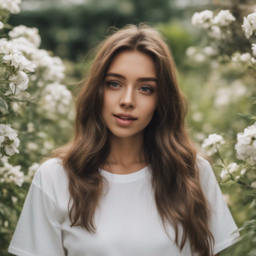

In [6]:
# read image prompt
image = Image.open("assets/images/girl.png")
image.resize((256, 256))

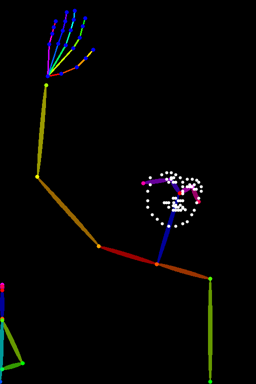

In [7]:
openpose_image = Image.open("assets/structure_controls/openpose.png")
openpose_image.resize((256, 384))

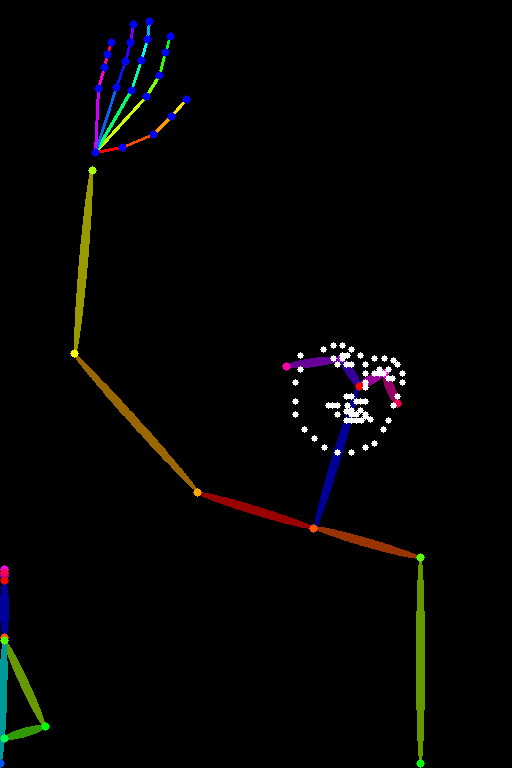

In [11]:
openpose_image

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [ ]:
# generate
images = ip_model.generate(pil_image=image, image=openpose_image, width=512, height=768, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid